In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics,cluster 
from umap import UMAP
import multiscale_phate as mp

import scanpy as sc
import scprep

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
adata = sc.read_h5ad('Tosches_turtle.h5ad')
adata

AnnData object with n_obs × n_vars = 18664 × 23500
    obs: 'sample', 'region', 'donor', 'cell_type1', 'gender', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes'
    uns: 'author_genes', 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'donor_colors', 'gender_colors', 'neighbors', 'region_colors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [3]:
data_group = adata.obs['cell_ontology_class']
n_groups = 8
set(data_group)

{'GABAergic inhibitory interneuron',
 'ependymoglial cell',
 'glutamatergic neuron',
 'leukocyte',
 'microglial cell',
 'nan',
 'oligodendrocyte',
 'oligodendrocyte precursor cell'}

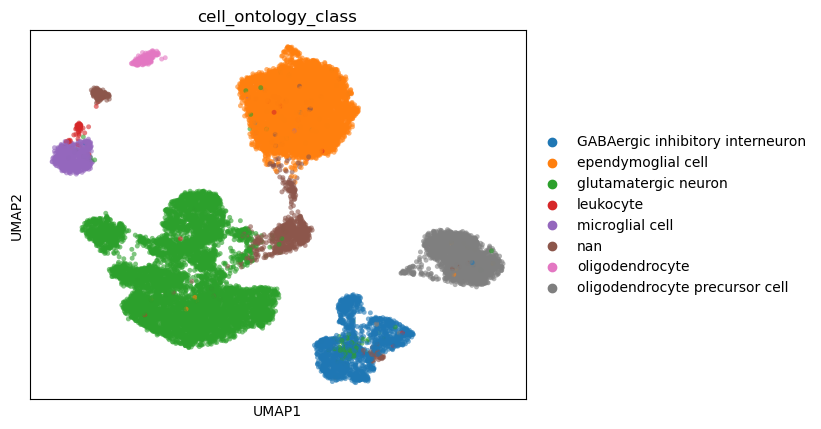

In [4]:
# # sc.pp.neighbors(adata)
# sc.tl.leiden(adata, resolution=0.068, use_weights=True)
# sc.tl.louvain(adata,resolution=0.08, use_weights=True)
sc.pl.umap(adata, color=['cell_ontology_class'], s=50, alpha=0.6, ncols=2,show = True,)

In [5]:
cell_ontology_class = adata.obs['cell_ontology_class']
turtle_cluster_set = set(cell_ontology_class)
turtle_zip_types = zip(sorted(turtle_cluster_set),range(len(turtle_cluster_set)))
turtle_dict_types = dict(turtle_zip_types)
turtle_cell_clusters  =  [turtle_dict_types[i] for i in cell_ontology_class]

In [6]:
X_umap = pd.DataFrame(adata.obsm['X_umap'],data_group)

Text(3.4588141441345215, 12.489397048950195, 'ependymoglial cell')

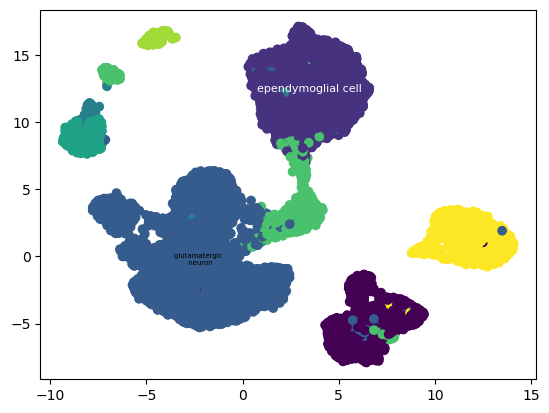

In [7]:
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=turtle_cell_clusters)
plt.annotate('glutamatergic \n neuron', 
                 X_umap.loc[X_umap.index=='glutamatergic neuron',[0,1]].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=5, ) # weight='bold',
plt.annotate('ependymoglial cell', 
                 X_umap.loc[X_umap.index=='ependymoglial cell',[0,1]].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=8,  color='white') # weight='bold',

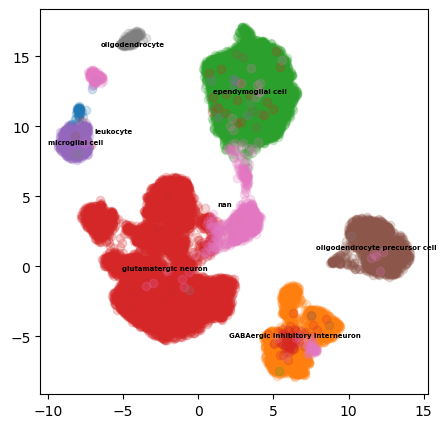

In [8]:
plt.figure(figsize=(5,5))

#loop through labels and plot each cluster
for i, label in enumerate(list(set(data_group))):

    #add data points 
    plt.scatter(x=X_umap.loc[X_umap.index==label, 0], 
                y=X_umap.loc[X_umap.index==label, 1], 
                # color=customPalette[i], 
                alpha=0.20)
    
    #add label
    plt.annotate(label, 
                 X_umap.loc[X_umap.index==label,[0,1]].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=5, weight='bold',) 

C:\Users\Jon\AppData\Local\Temp\ipykernel_26864\427633644.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.068, use_weights=True)


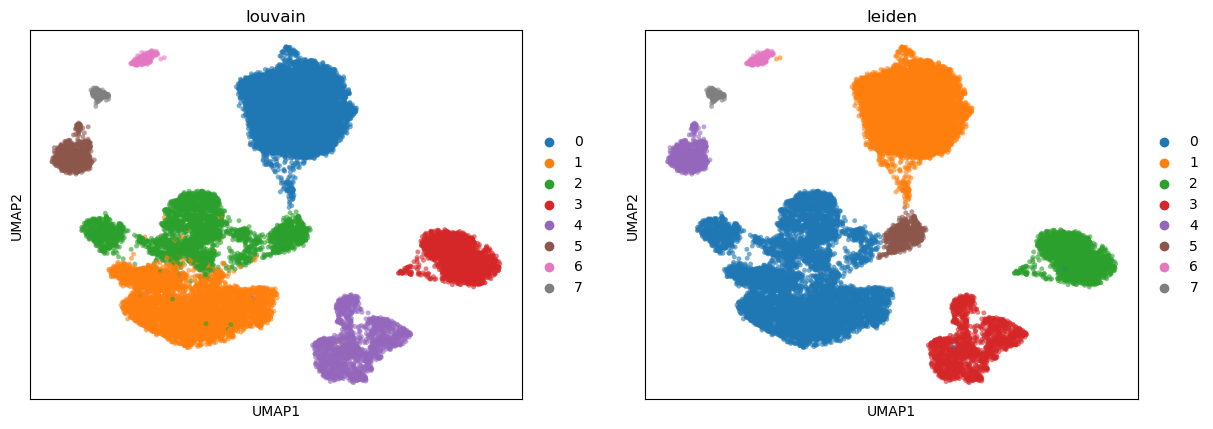

leiden: 0.9588478596246023 0.9180333571895046
louvain: 0.7732526348468615 0.8293777148360776


In [9]:
# sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.068, use_weights=True)
sc.tl.louvain(adata,resolution=0.08, use_weights=True)
sc.pl.umap(adata, color=['louvain', 'leiden'], s=50, alpha=0.6, ncols=2)

leiden_group = np.array(adata.obs['leiden'].values).astype('int')
ari_leiden = metrics.adjusted_rand_score(leiden_group, data_group)
ami_leiden = metrics.adjusted_mutual_info_score(leiden_group, data_group)

louvain_group = np.array(adata.obs['louvain'].values).astype('int')
ari_louvain = metrics.adjusted_rand_score(louvain_group, data_group)
ami_louvain = metrics.adjusted_mutual_info_score(louvain_group, data_group)

print("leiden:",ari_leiden,ami_leiden)
print("louvain:",ari_louvain,ami_louvain)

In [10]:
cell_ontology_group = np.array(data_group.values.reshape(-1))

In [11]:
from dtne import *

In [12]:
X = adata.obsm['latent']

In [13]:
embedding = DTNE(k_neighbors = 30) 
Y = embedding.fit_transform(X)
dtne_cluster = embedding.cluster_cells(n_clusters=n_groups)

ari_dtne = metrics.adjusted_rand_score(dtne_cluster, data_group)
ami_dtne = metrics.adjusted_mutual_info_score(dtne_cluster, data_group)
print("dtne:",ari_dtne,ami_dtne)

dtne: 0.9634997009395972 0.9248272582714052


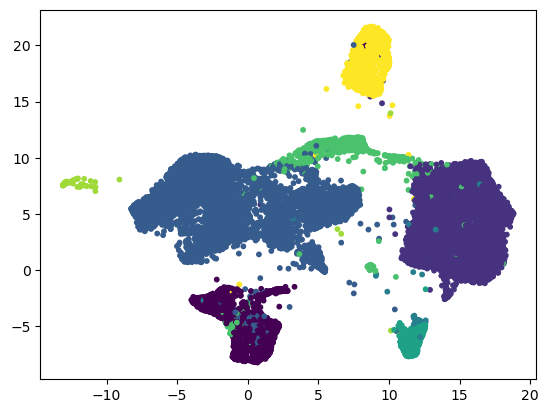

In [14]:
embedding = DTNE(k_neighbors = 30, min_dist = 0.9, solver = 'umap') 
Y2 = embedding.fit_transform(X)
plt.scatter(Y2[:,0], Y2[:,1], c=turtle_cell_clusters,s=10,cmap='viridis')

In [15]:
agglo_instance = cluster.AgglomerativeClustering(n_clusters=n_groups).fit(X)
agglo_groups = agglo_instance.labels_
ari_agglo = metrics.adjusted_rand_score(agglo_groups, data_group)
ami_agglo = metrics.adjusted_mutual_info_score(agglo_groups, data_group)

print("hierarchical:",ari_agglo,ami_agglo)

hierarchical: 0.7823302297951082 0.8367379316043236


In [16]:
mp_op = mp.Multiscale_PHATE(random_state=0,n_jobs=-2,)
levels = mp_op.fit(X)
levels

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculating diffusion potential...
  Calculated diffusion potential in 10.48 seconds.
  Setting epsilon to 3.3757
  Setting merge threshold to 0.5239
  Calculating condensation...
  Calculated condensation in 25.32 seconds.
Calculated Multiscale PHATE tree in 37.56 seconds.
Computing gradient...
Identifying salient levels of resolution...


[0, 12, 48, 68, 91, 97, 106, 114, 126, 131, 138, 147]

In [17]:
tree_clusters = mp_op.get_tree_clusters(129)
set(tree_clusters)

{0, 6, 18, 28, 43, 246, 465, 1955, 7417}

In [18]:
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = 0,cluster_level = 129)
set(mp_clusters)

{0, 6, 18, 28, 43, 246, 465, 1955, 7417}

In [19]:
ari_mp = metrics.adjusted_rand_score(mp_clusters, data_group)
ami_mp = metrics.adjusted_mutual_info_score(mp_clusters, data_group)
print("Multiscale PHATE:",ari_mp,ami_mp)

Multiscale PHATE: 0.858393695341016 0.8336796120057812


In [20]:
pd.DataFrame([cell_ontology_group,leiden_group,louvain_group,dtne_cluster,agglo_groups,mp_clusters],index=["cell_ontology_class","leiden_group","louvain_group","dtne_group","hierarchical_group","MS-PHATE"]).to_csv("Tosches_turtle_clustering.csv")
pd.DataFrame(adata.obsm['X_umap']).to_csv("Tosches_turtle_umap.csv")

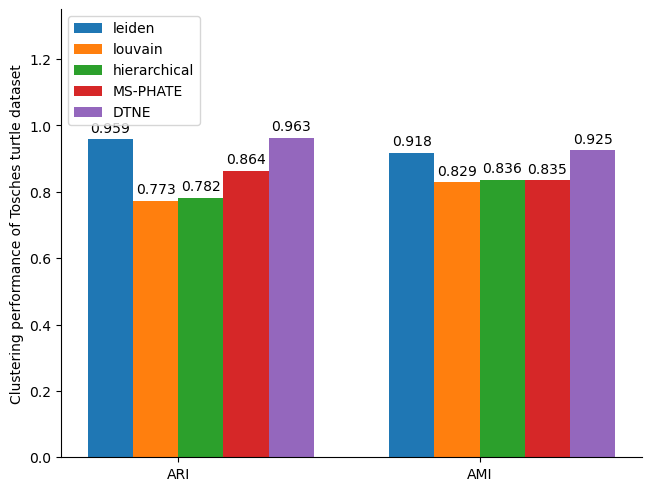

In [21]:
correlation = ['ARI','AMI']
pseudotime_corr = {
    'leiden':(0.959, 0.918),
    'louvain':(0.773, 0.829),
    'hierarchical':(0.782, 0.836),
    'MS-PHATE':(0.864, 0.835),
    'DTNE':(0.963, 0.925)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Clustering performance of Tosches turtle dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.35)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.savefig('./Tosches_turtle_plot.png', format='png', dpi=1000)
plt.savefig('./Tosches_turtle_plot.pdf', format='pdf', dpi=1000)